Fermi GBM Localizations using the DoL
-------------------------------------

This example shows how to localize a Gamma-ray Burst (GRB) using the Fermi Gamma-ray Burst Monitor (GBM).  This example uses concepts first introduced, and explained, in the **SwiftBatLightcurves** example.

---

Non-imaging hard X-ray and gamma-ray instruments such as GBM are not able to identify the location of each photon they detect.  Instead, they rely on orienting their detectors at different parts of the sky and utilizing the resulting difference in angular responses to localize bright signals to within a few degrees on the sky.

We will localize the famous GRB 170817A, a binary neutron star merger.  To do so, we will utilize the trig|ger data (trigdat) for the on-board trigger corresponding to this GRB. The trigdat file contains data from all 14 GBM detectors as well as the spacecraft position and orientation during the trigger. We import the [`Trigdat`](https://astro-gdt.readthedocs.io/projects/astro-gdt-fermi/en/latest/api/gdt.missions.fermi.gbm.trigdat.Trigdat.html#gdt.missions.fermi.gbm.trigdat.Trigdat) class and use it to open the trigdat file.  Once we open the file, we can print the handle to see some basic information about the file.

In [1]:
from gdt.missions.fermi.gbm.trigdat import Trigdat
trigdat = Trigdat.open("data/glg_trigdat_all_bn170817529_v01.fit")
print(trigdat)

<Trigdat: glg_trigdat_all_bn170817529_v01.fit;
 trigtime=524666471.47; triggered detectors=['n1', 'n2', 'n5']>


We can now plot the lightcurve of the data contained in this file. Since trigdat contains data from all detectors, and since many of those detectors may not have significant signal, we will sum together the data from the triggered detectors only in order to create our lightcurve.  The GBM trigdat contains multiple timescales that span a variety of time ranges, and we will choose to plot the lightcurve down to 64 ms, the shortest timescale in the trigdat.  Our final choice for plotting will be to restrict the energy range to 50-300 keV so that it is easier to see the GRB signal.

We import the [`Lightcurve`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.plot.lightcurve.Lightcurve.html#gdt.core.plot.lightcurve.Lightcurve) class to perform the plotting.  The concept for lightcurve plotting is explained in the **SwiftBatLightcurves** example. Upon visual inspection, we see that the GRB appears in the lightcurve as a single pulse from approximately -0.256 s to +0.448 s around the trigger time, so we also highlight that selection in the lightcurve and use it as our source window over which to calculate the localization.


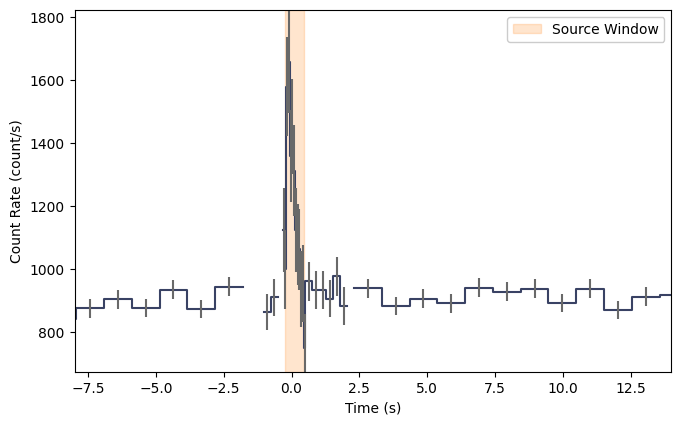

In [2]:
from gdt.core.plot.lightcurve import Lightcurve

# plot over this energy range
loc_erange = (50.0, 300.0)

# zoom in to this time range
lc_range = (-8.0, 14.0)

# the source selection
src_time = (-0.256, 0.448)

# sum together data from the triggered detectors going down to the 64 ms timescale.
summed_phaii = trigdat.sum_detectors(trigdat.triggered_detectors, timescale=64)

# slice to our energy range
summed_phaii = summed_phaii.slice_energy(loc_erange)

lcplot = Lightcurve(summed_phaii.to_lightcurve())
src_span = lcplot.ax.axvspan(*src_time, color='C1', alpha=0.2)
lcplot.ax.legend([src_span], ["Source Window"], framealpha=1.0,)
lcplot.xlim = lc_range

Now we will retrieve the observed counts and exposure during this source window for each detector.  We will import the [`GbmDetectors`](https://astro-gdt.readthedocs.io/projects/astro-gdt-fermi/en/latest/api/gdt.missions.fermi.gbm.detectors.GbmDetectors.html#gdt.missions.fermi.gbm.detectors.GbmDetectors) class that easily allows us to iterate over all of the GBM detectors.

In [3]:
import numpy as np
from gdt.missions.fermi.gbm.detectors import GbmDetectors

# the time range of the source we want to localize
src_time = (-0.256, 0.448)


src_counts = []
src_exposure = []
for det in GbmDetectors:
    # retrieve the data for each individual detector
    phaii = trigdat.to_phaii(det.name, timescale=64)

    # integrate the data over our time range to get the count spectrum
    bin = phaii.data.integrate_time(*src_time)

    # extract the observed counts
    src_counts.append(bin.counts.astype(int))

    # extract the exposure
    src_exposure.append(bin.exposure)
    
    print(f" - {det.name} {src_counts[-1]}")

avg_src_exposure = np.sum(src_exposure) / np.array(src_exposure).size
print(f" Exposure {avg_src_exposure:.3f}")

 - n0 [ 48 267 176 127 135  25  18  77]
 - n1 [ 50 301 188 153 155  27  30  66]
 - n2 [ 55 285 190 162 141  31  54  33]
 - n3 [ 64 316 171 131 126  32  22  55]
 - n4 [ 51 293 188 147 113  26  52  27]
 - n5 [ 65 367 217 177 149  30  46  23]
 - n6 [ 54 217 135 114 103  23  53  18]
 - n7 [ 70 275 182 135 107  22  26  58]
 - n8 [ 59 252 155 121 116  21  43  32]
 - n9 [ 48 179 152 115 116  30  82  13]
 - na [ 34  89 110 146 104  25  59  27]
 - nb [ 33 120 101 155 122  44  29  74]
 - b0 [374 204 318 128  26  10  15  95]
 - b1 [358 219 258 103  37  26  15  85]
 Exposure 0.768


We printed out the observed counts in each of the 8 trigdat energy channels in each of the GBM detectors during our source time range as well as the exposure averaged over the detectors.

Next, we need an estimate for the background counts within the source window. Since the background is fairly linear at times outside our window, we use a first order polynomial fit to estimate the background. We perform the fit on two background periods, one just before and one just after the source window. The concept for background fitting is explained in the **SwiftBatLightcurves** example. Then we extract the background counts and exposure from each detector like we just did for the observed counts and exposure.

In [4]:
from gdt.core.background.fitter import BackgroundFitter
from gdt.core.background.binned import Polynomial

# time ranges during which to fit the background
back_times = [(-5.0, -1.0), (5.0, 10.0)]

back_counts = []
back_exposure = []
back_trigdet = []
for det in GbmDetectors:
    # retrieve the data for each individual detector    
    phaii = trigdat.to_phaii(det.name, timescale=64)
    
    # initialize the background fitter and fit the background with a 1st order polynomial
    fitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=back_times)
    fitter.fit(order=1)

    # interpolate the background model during the full lightcurve
    back_rates = fitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)

    # integrate the background during our source window to get the background count spectrum
    bin = back_rates.integrate_time(*src_time)

    # extract the background counts
    back_counts.append(bin.counts.astype(int))

    # extract the background exposure
    back_exposure.append(bin.exposure)

    # keep this around to overplot the background model below
    if det.name in trigdat.triggered_detectors:
        back_trigdet.append(back_rates.slice_energy(*loc_erange))

    print(f" - {det.name} {back_counts[-1]}")

avg_back_exposure = np.sum(back_exposure) / np.array(back_exposure).size
print(f" Exposure {avg_back_exposure:.3f}")

 - n0 [ 50 236 156 122 110  32  22  65]
 - n1 [ 50 256 166 124 104  26  32  59]
 - n2 [ 51 234 159 114 114  29  51  36]
 - n3 [ 64 304 187 129 103  24  17  52]
 - n4 [ 56 304 196 123 104  24  37  32]
 - n5 [ 64 301 190 122 117  29  48  24]
 - n6 [ 50 220 140 108 104  24  54  15]
 - n7 [ 62 269 171 123 100  25  29  42]
 - n8 [ 51 253 157 114 104  28  43  38]
 - n9 [ 40 197 141 123 111  27  77  14]
 - na [ 46  97 114 111 105  27  61  28]
 - nb [ 27 121 112 103 117  31  26  61]
 - b0 [367 220 264 117  26  17  17  85]
 - b1 [303 242 259 104  25  21  17  84]
 Exposure 0.768


We now have the modeled background counts in each of the 8 trigdat channels for each detector.

Now, we can plot the background model to see what it looks like.

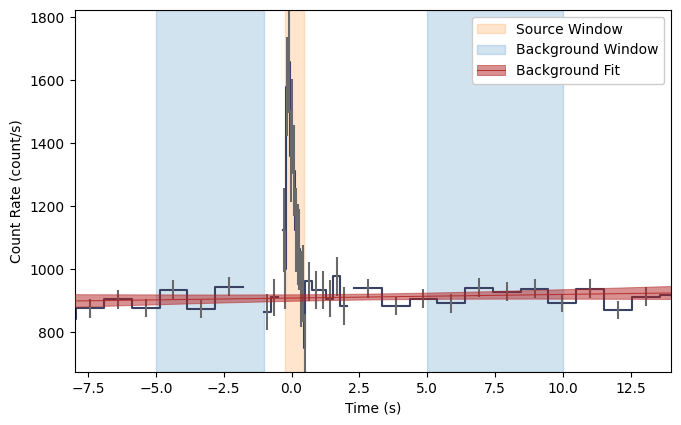

In [5]:
# sum the backgrounds for the triggered detectors
back_trigdet_sum = back_trigdet[0].sum_time(back_trigdet)

lcplot = Lightcurve(summed_phaii.to_lightcurve())

# the source and background selections
src_span = lcplot.ax.axvspan(*src_time, color='C1', alpha=0.2)
back_span = lcplot.ax.axvspan(*back_times[0], color='C0', alpha=0.2)
_ = lcplot.ax.axvspan(*back_times[1], color='C0', alpha=0.2)

# set the background fit
lcplot.set_background(back_trigdet_sum)

lcplot.ax.legend([src_span, back_span, tuple(lcplot.background.artists)],
                 ["Source Window", "Background Window", "Background Fit"], framealpha=1.0,)
lcplot.xlim = lc_range

We now have arrays with the measured source counts `src_counts` and estimated background counts `back_counts` needed to perform a localization. Now we need to specify the energy channel range over which we will perform the localization. Typically, GBM uses data covering 50-300 keV for GRB localizations, so we will determine what channel range corresponds to that energy range.

In [6]:
# the list of energy edges (to be used later)
energies = np.append(phaii.ebounds.low_edges(), phaii.ebounds.high_edges()[-1])

# the channel range corresponding to our localization energy range
chan_range = [phaii.ebounds.index(loc_erange[0]), phaii.ebounds.index(loc_erange[1])]
print(chan_range)

[3, 4]


We also need to extract the position and orientation of the spacecraft to determine the conversion between the spacecraft frame, where the localization calculation is performed, and the celestial frame.  To do this, we will need to import [`Time`](https://astro-gdt.readthedocs.io/projects/astro-gdt-fermi/en/latest/missions/fermi/time.html) from gdt-fermi, which will give us the Fermi epoch. Because our source window is short, Fermi's movement during the window is negligible, so we can use the spacecraft position and orientation at the center of the window.  

In [7]:
from gdt.missions.fermi.time import Time

# center of our source window (trigger time + center of source time)
tcenter = trigdat.trigtime + 0.5 * sum(src_time)

# the Fermi spacecraft frame at the center of our source window
frame = trigdat.poshist.at(Time(tcenter, format='fermi'))

# extract the spacecraft position (Cartesian coordinates in km relative to Earch center)
scpos = frame.obsgeoloc.xyz.to_value('km')

# extract the quaternion that describes the rotation between the ICRS frame and the spacecraft frame
quaternion = frame.quaternion.scalar_last

Note that this is done using the central time of the source window. It does not account for spacecraft motion so you should limit the source window length to less than ~1 min, even for long GRBs. It is recommended to fit the brightest peak when using the DoL algorithm to localize GRBs with durations longer than 1 minute.

Lastly, we’ll gather information about the final flight software localization from this onboard trigger. This is only used to compare our localization to the best onboard localization, so you can set these values to anything.

In [8]:
ra = trigdat.headers['PRIMARY']['RA_OBJ']
dec = trigdat.headers['PRIMARY']['DEC_OBJ']


---
We now have the following variables defined:
* `chan_range`: list with the energy bin range corresponding to 50-300 keV
* `src_counts`: list containing the observed counts during the source window for all GBM detectors. The shape is (14, 8) since there are 14 detectors, each with 8 energy bins.
* `back_counts`: list containing the estimated background counts during the source window for all GBM detectors. The shape is (14, 8) since there are 14 detectors, each with 8 energy bins.
* `avg_src_exposure`: average exposure in seconds across the source window for all GBM detectors.
* `avg_back_exposure`: average exposure in seconds for the background estimate across the source window for all GBM detectors.
* `scpos`: list with spacecraft position relative to Earth center in km
* `quaternion`: list with spacecraft rotation information. Format is scalar last.
* `energies`: energy bin edges in keV
* `ra`: initial guess for source right ascension in degrees
* `dec`: initial guess for source declination in degrees
* `tcenter`: central time of the source window in Fermi mission elapsed seconds (MET)
* `frame`: object defining the spacecraft state at tcenter

We are now ready to perform a localization.  We will use and algorithm called the DoL (Daughter of LocBurst), which is the algorithm that GBM uses in operations and it traces its heritage from LocBurst, the algorithm used by BATSE to localize GRBs.  We will import [`legacy_DoL`](https://astro-gdt.readthedocs.io/projects/astro-gdt-fermi/en/latest/api/gdt.missions.fermi.gbm.localization.dol.legacy_dol.legacy_DoL.html#gdt.missions.fermi.gbm.localization.dol.legacy_dol.legacy_DoL), initialize it, and pass it all but the `frame` variable (which we will use later).  Note that the `scat_opt=1` option accounts for atmospheric scattering during the localization.


In [9]:
from gdt.missions.fermi.gbm.localization.dol.legacy_dol import legacy_DoL

dol = legacy_DoL()
loc = dol.eval(chan_range, np.array(src_counts), np.array(back_counts),
               avg_src_exposure, avg_back_exposure,
               scpos, quaternion, energies, ra, dec, int(tcenter),
               scat_opt=1)

The [`eval()`](https://astro-gdt.readthedocs.io/projects/astro-gdt-fermi/en/latest/api/gdt.missions.fermi.gbm.localization.dol.legacy_dol.legacy_DoL.html#gdt.missions.fermi.gbm.localization.dol.legacy_dol.legacy_DoL.eval) method will take a few seconds to complete before returning the localization result as a dictionary object. Now we can retrieve our localization results in celestial coordinates.  The best RA, Dec, and localization uncertainty (68% containment), all in degrees can be retrieved with the following:

In [10]:
np.degrees([loc["best"]["ra"], loc["best"]["dec"]]), loc["best"]["err"]

(array([191.2391 , -38.14466], dtype=float32), np.float32(17.080418))

Similarly, we can retrieve the localization in the spacecraft frame (azimuth and zenith).

In [11]:
np.degrees([loc["best"]["az"], loc["best"]["zen"]])

array([33.     , 93.99999], dtype=float32)

We can also make a map of the localization posterior probability.  We will convert our localization to a HEALPix map, which will be contained in a [`GbmHealPix`](https://astro-gdt.readthedocs.io/projects/astro-gdt-fermi/en/latest/api/gdt.missions.fermi.gbm.localization.GbmHealPix.html) object.  We pass it the `frame` variable that contains the spacecraft frame information because it will allow us to plot the detector orientations and Earth occultation region on the map.

In [12]:
healpix = dol.to_GbmHealPix(loc, frame)

To plot the map, we will import the [`EquatorialPlot`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.plot.sky.EquatorialPlot.html) class, which will make a full-sky plot.  We add our `GbmHealPix` object, specify that we want to plot contours at the 50% and 90% containment and that we want filled contours (`gradient=False`).

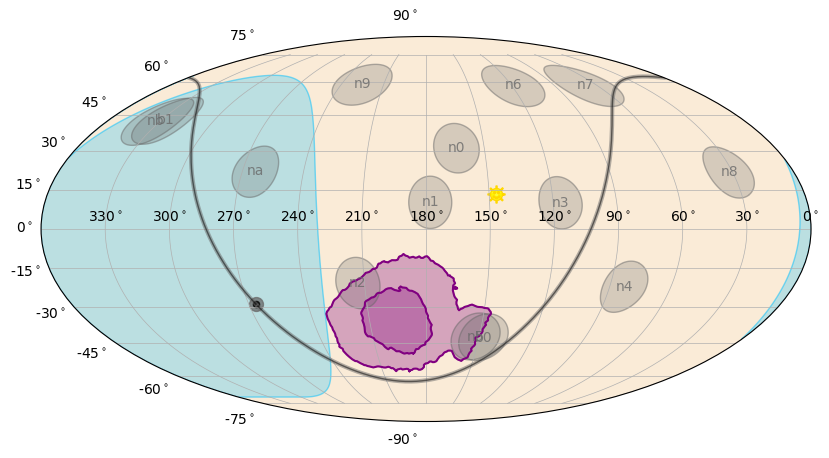

In [13]:
from gdt.core.plot.sky import EquatorialPlot

skyplot = EquatorialPlot()
skyplot.add_localization(healpix, clevels=[0.50, 0.90], gradient=False)

This plot not only contains the localization (purple contours), but it contains the Earth occultation region (blue), the detector pointings (gray), the Sun (yellow), and an indicator of the Galactic Plane.

The localization that we performed only incorporates the statistical uncertainty.  We can apply one of the systematic uncertainty models developed for GBM localizations by convolving the model with our current posterior distribution.  In this example, let us use the model designed for Human-in-the-loop localizations, [`hitl_model()`](https://astro-gdt.readthedocs.io/projects/astro-gdt-fermi/en/latest/api/gdt.missions.fermi.gbm.localization.hitl_model.html). This model requires an input of the best-known azimuthal arrival direction.

In [14]:
from gdt.missions.fermi.gbm.localization import hitl_model

az = np.degrees(loc["best"]["az"])

# convolve the current healpix map with the HITL systematic model and return a new map.
healpix = healpix.convolve(hitl_model, az)

As a final step before plotting, we remove the Earth region from the probability map because gamma-ray sources cannot penetrate the Earth. This must be done after convolution with the systematic model to avoid smearing the region blocked by the Earth into visible parts of the sky.

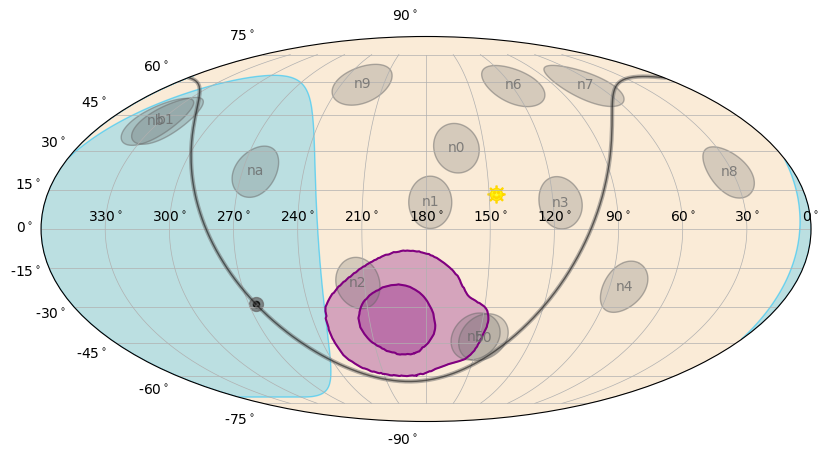

In [15]:
healpix = healpix.remove_earth()

skyplot = EquatorialPlot()
skyplot.add_localization(healpix, clevels=[0.50, 0.90], gradient=False)